# Assignment #1: PFL067 Statistical NLP

## Exploring Entropy and Language Modeling

### Author: Dan Kondratyuk
---

### 1. Entropy of a Text

#### Problem Statement
> In this experiment, you will determine the conditional entropy of the word distribution in a text given the previous word. To do this, you will first have to compute P(i,j), which is the probability that at any position in the text you will find the word i followed immediately by the word j, and P(j|i), which is the probability that if word i occurs in the text then word j will follow. Given these probabilities, the conditional entropy of the word distribution in a text given the previous word can then be computed as:

> $$H(J|I) = -\sum_{i \in I, j \in J} P(i,j) \log_2 P(j|i)$$

> The perplexity is then computed simply as

> $$P_X(P(J|I)) = 2^{H(J|I)}$$

> Compute this conditional entropy and perplexity for `TEXTEN1.txt`. This file has every word on a separate line. (Punctuation is considered a word, as in many other cases.) The i,j above will also span sentence boundaries, where i is the last word of one sentence and j is the first word of the following sentence (but obviously, there will be a fullstop at the end of most sentences).

> Next, you will mess up the text and measure how this alters the conditional entropy. For every character in the text, mess it up with a likelihood of 10%. If a character is chosen to be messed up, map it into a randomly chosen character from the set of characters that appear in the text. Since there is some randomness to the outcome of the experiment, run the experiment 10 times, each time measuring the conditional entropy of the resulting text, and give the min, max, and average entropy from these experiments. Be sure to use srand to reset the random number generator seed each time you run it. Also, be sure each time you are messing up the original text, and not a previously messed up text. Do the same experiment for mess up likelihoods of 5%, 1%, .1%, .01%, and .001%.

> Next, for every word in the text, mess it up with a likelihood of 10%. If a word is chosen to be messed up, map it into a randomly chosen word from the set of words that appear in the text. Again run the experiment 10 times, each time measuring the conditional entropy of the resulting text, and give the min, max, and average entropy from these experiments. Do the same experiment for mess up likelihoods of 5%, 1%, .1%, .01%, and .001%.

> Now do exactly the same for the file `TEXTCZ1.txt`, which contains a similar amount of text in an unknown language (just FYI, that's Czech*)

> Tabulate, graph and explain your results. Also try to explain the differences between the two languages. To substantiate your explanations, you might want to tabulate also the basic characteristics of the two texts, such as the word count, number of characters (total, per word), the frequency of the most frequent words, the number of words with frequency 1, etc.

### Process Text
Define functions to calculate probabilites of bigrams/unigrams and conditional entropy of a text.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections as c
from collections import defaultdict
import pickle

In [2]:
# Set a seed so that this notebook is repeatable
np.random.seed(200)

In [3]:
english = './TEXTEN1.txt'
czech = './TEXTCZ1.txt'

In [4]:
def open_text(filename):
    """Reads a text line by line, applies light preprocessing, and returns an array of words"""
    with open(filename, encoding='iso-8859-2') as f:
        content = f.readlines()
    
    preprocess = lambda word: word.strip()
    
    return np.array([preprocess(word) for word in content])

In [5]:
# Read the texts into memory
words_en, words_cz = open_text(english), open_text(czech)

In [6]:
class BigramModel:
    """Counts up bigrams and calculates probabilities"""
    
    def __init__(self, words):
        self.words = words
        self.word_set = list(set(words))
        self.word_count = len(self.word_set)
        self.total_word_count = len(self.words)
        self.unigram_dist = c.Counter(words)
        
        self.bigrams = list(nltk.bigrams(words))
        self.bigram_set = list(set(self.bigrams))
        self.bigram_count = len(self.bigram_set)
        self.total_bigram_count = len(self.bigrams)
        self.dist = c.Counter(self.bigrams)
    
    def p_bigram(self, wprev, w):
        """Calculates the probability a bigram appears in the distribution"""
        return self.dist[(wprev, w)] / self.total_bigram_count

    def p_bigram_cond(self, wprev, w):
        """Calculates the probability a word appears in the distribution given the previous word"""
        return self.dist[(wprev, w)] / self.unigram_dist[wprev]
    
    def entropy_cond(self):
        """Calculates the conditional entropy from a list of bigrams"""
        bigram_set = self.bigram_set
        return - np.sum(self.p_bigram(*bigram) * 
                        np.log2(self.p_bigram_cond(*bigram)) 
                        for bigram in bigram_set)

    def perplexity_cond(self, entropy=-1):
        """Calculates the conditional perplexity from the given conditional entropy"""
        if (entropy < 0):
            return 2 ** self.entropy_cond()
        else:
            return 2 ** entropy

### Basic Text Statistics
Here we can see basic text stats of each language's text.

In [7]:
def text_stats(words):
    """Given a list of words, this calculates various statistical 
    properties like entropy, number of characters, etc"""
    bigram_model = BigramModel(words)
    
    entropy = bigram_model.entropy_cond()
    perplexity = bigram_model.perplexity_cond(entropy=entropy)
    vocab_size = bigram_model.word_count
    char_count = len([char for word in words for char in word])
    chars_per_word = char_count / len(words)
    words_freq_1 = sum(1 for key in bigram_model.unigram_dist if bigram_model.unigram_dist[key] == 1)
    most_freq_words = bigram_model.unigram_dist.most_common()[:10]

    return [entropy, perplexity, vocab_size, char_count, chars_per_word, words_freq_1, most_freq_words]

In [8]:
text_stats_cols = [
    'entropy', 'perplexity', 'vocab_size', 'char_count', 
    'chars_per_word', 'words_freq_1', 'most_freq_words'
]

In [9]:
def text_stats_lang(filename):
    """Calculates statistics from a file and arranges them in a nicely formatted table"""
    return pd.DataFrame([text_stats(open_text(filename))], columns=text_stats_cols)

In [10]:
# English stats
text_stats_lang(english)

,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,5.287452,39.055456,9607,972917,4.400388,3811,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."


In [11]:
# Czech stats
text_stats_lang(czech)

,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,4.747848,26.868573,42826,1030631,4.633882,26315,"[(,, 13788), (., 12931), (a, 4486), (v, 4043),..."


### Perturb Texts
Define functions to process each text and perturb characters/words with a given probability.

In [12]:
def charset(words):
    """Given a list of words, calculates the set of characters over all words"""
    return np.array(list(set(char for word in words for char in word)))

In [13]:
charset(words_en)[:10]

array(['E', 'M', 'o', 'h', 'R', "'", 'k', 'X', 'C', 'd'],
      dtype='<U1')

In [14]:
def vocab_list(words):
    """Given a list of words, calculates the set of words (vocabulary)"""
    return np.array(list(set(word for word in words)))

In [15]:
vocab_list(words_en)[:10]

array(['setter', 'conspicuous', 'Continued', 'experiment', 'descendant',
       'literal', 'epidemics', 'roses', 'shorter', 'done'],
      dtype='<U18')

In [16]:
def perturb_char(word, charset, prob=0.1):
    """Changes each character with given probability to a random character in the charset"""
    return ''.join(np.random.choice(charset) if np.random.random() < prob else char for char in word)

In [17]:
def perturb_word(word, vocabulary, prob=0.1):
    """Changes a word with given probability to a random word in the vocabulary"""
    return np.random.choice(vocabulary) if np.random.random() < prob else word

In [18]:
def perturb(words, charset, vocabulary, prob=0.1):
    """Perturbs a list of words with given probability on the character level and word level"""
    pchars = list(map(lambda word: perturb_char(word, charset, prob=prob), words))
    pwords = list(map(lambda word: perturb_word(word, vocabulary, prob=prob), words))
    
    return pchars, pwords

In [19]:
def perturb_text(words, seed=200):
    """Perturbs a list of words for a predefined list of probabilties"""
    np.random.seed(seed)
    
    chars, vocab = charset(words), vocab_list(words)
    text_chars, text_words = pd.DataFrame(), pd.DataFrame()
    
    for prob in [0, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1]:
        text_chars[str(prob)], text_words[str(prob)] = perturb(words, chars, vocab, prob=prob)
    
    return text_chars, text_words

In [20]:
perturbed_en = perturb_text(words_en)
perturbed_cz = perturb_text(words_cz)

In [21]:
with open('perturbed_en.pkl', 'wb') as f:
    pickle.dump(perturbed_en, f)
with open('perturbed_cz.pkl', 'wb') as f:
    pickle.dump(perturbed_cz, f)

In [22]:
with open('perturbed_en.pkl', 'rb') as f:
    perturbed_en = pickle.load(f)
with open('perturbed_cz.pkl', 'rb') as f:
    perturbed_cz = pickle.load(f)

### Entropy Statistics
Calculate, tabulate, and plot the entropy (and other statistics) with respect to the type and amount of perturbation made to a text.

In [23]:
def all_stats(perturbed_text):
    """Calculates statistics for all perturbed probabilities of a given text 
    and outputs them to two tables (character and word level respectively)"""
    text_chars, text_words = perturbed_text
    
    col_names = ['prob'] + text_stats_cols
    
    char_stats = pd.DataFrame(columns=col_names)
    word_stats = pd.DataFrame(columns=col_names)
    
    # Iterate through all perturbation probabilities and gather statistics
    for col in text_chars:
        stat = text_stats(list(text_chars[col]))
        char_stats.loc[len(char_stats)] = [float(col)] + stat
    
    for col in text_words:
        stat = text_stats(list(text_words[col]))
        word_stats.loc[len(word_stats)] = [float(col)] + stat
    
    return char_stats, word_stats

In [24]:
char_stats_en, word_stats_en = all_stats(perturbed_en)
char_stats_cz, word_stats_cz = all_stats(perturbed_cz)

In [25]:
char_stats_en

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,5.287452,39.055456,9607,972917,4.400388,3811,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
1,0.00001,5.287433,39.054949,9615,972917,4.400388,3820,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
2,0.00010,5.287346,39.052594,9706,972917,4.400388,3910,"[(,, 14720), (the, 13295), (of, 9363), (., 564..."
3,0.00100,5.283056,38.936629,10472,972917,4.400388,4674,"[(,, 14705), (the, 13266), (of, 9347), (., 563..."
4,0.01000,5.248243,38.008300,17747,972917,4.400388,11656,"[(,, 14586), (the, 12916), (of, 9159), (., 558..."
5,0.05000,5.052525,33.186515,42426,972917,4.400388,34665,"[(,, 14002), (the, 11446), (of, 8508), (., 538..."
6,0.10000,4.726798,26.479385,64493,972917,4.400388,55234,"[(,, 13255), (the, 9759), (of, 7604), (., 5150..."


In [26]:
word_stats_en

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,5.287452,39.055456,9607,972917,4.400388,3811,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
1,0.00001,5.287410,39.054307,9607,972924,4.400420,3810,"[(,, 14721), (the, 13299), (of, 9368), (., 564..."
2,0.00010,5.287612,39.059769,9607,972980,4.400673,3805,"[(,, 14719), (the, 13296), (of, 9367), (., 564..."
3,0.00100,5.289613,39.113986,9602,973666,4.403776,3716,"[(,, 14703), (the, 13280), (of, 9361), (., 563..."
4,0.01000,5.306663,39.578994,9575,979945,4.432175,3018,"[(,, 14588), (the, 13152), (of, 9265), (., 558..."
5,0.05000,5.376936,41.554598,9552,1006568,4.552588,1258,"[(,, 14012), (the, 12680), (of, 8905), (., 538..."
6,0.10000,5.459364,43.997924,9560,1040280,4.705063,468,"[(,, 13212), (the, 11987), (of, 8441), (., 505..."


In [27]:
char_stats_cz

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,4.747848,26.868573,42826,1030631,4.633882,26315,"[(,, 13788), (., 12931), (a, 4486), (v, 4043),..."
1,0.00001,4.747774,26.867198,42834,1030631,4.633882,26323,"[(,, 13788), (., 12930), (a, 4486), (v, 4043),..."
2,0.00010,4.746985,26.852513,42903,1030631,4.633882,26403,"[(,, 13786), (., 12931), (a, 4486), (v, 4043),..."
3,0.00100,4.738014,26.686055,43592,1030631,4.633882,27155,"[(,, 13770), (., 12918), (a, 4478), (v, 4039),..."
4,0.01000,4.656657,25.222806,50035,1030631,4.633882,34372,"[(,, 13659), (., 12801), (a, 4447), (v, 4014),..."
5,0.05000,4.337225,20.213189,73373,1030631,4.633882,60468,"[(,, 13110), (., 12306), (a, 4274), (v, 3884),..."
6,0.10000,4.001127,16.012502,94682,1030631,4.633882,84320,"[(,, 12489), (., 11719), (a, 4064), (v, 3697),..."


In [28]:
word_stats_cz

,prob,entropy,perplexity,vocab_size,char_count,chars_per_word,words_freq_1,most_freq_words
0,0.00000,4.747848,26.868573,42826,1030631,4.633882,26315,"[(,, 13788), (., 12931), (a, 4486), (v, 4043),..."
1,0.00001,4.747829,26.868229,42825,1030651,4.633972,26313,"[(,, 13787), (., 12930), (a, 4486), (v, 4043),..."
2,0.00010,4.747930,26.870110,42824,1030653,4.633981,26301,"[(,, 13788), (., 12930), (a, 4486), (v, 4043),..."
3,0.00100,4.747338,26.859083,42797,1031357,4.637146,26155,"[(,, 13777), (., 12921), (a, 4483), (v, 4037),..."
4,0.01000,4.737746,26.681101,42575,1038226,4.668031,24805,"[(,, 13623), (., 12792), (a, 4439), (v, 3992),..."
5,0.05000,4.699291,25.979304,41831,1065120,4.788950,20123,"[(,, 13090), (., 12297), (a, 4257), (v, 3829),..."
6,0.10000,4.637236,24.885551,41192,1099823,4.944980,15620,"[(,, 12473), (., 11634), (a, 4028), (v, 3653),..."


In [29]:
# Configure Plots
plt.rcParams['lines.linewidth'] = 3

In [30]:
def create_plot(label, word_stats, char_stats):
    plt.plot(word_stats.prob, word_stats.entropy, label='Word Entropy')
    plt.plot(char_stats.prob, char_stats.entropy, label='Character Entropy')
    plt.suptitle('Entropy (' + label + ')')
    plt.xlabel('Probability')
    plt.ylabel('Entropy')
    _ = plt.legend()

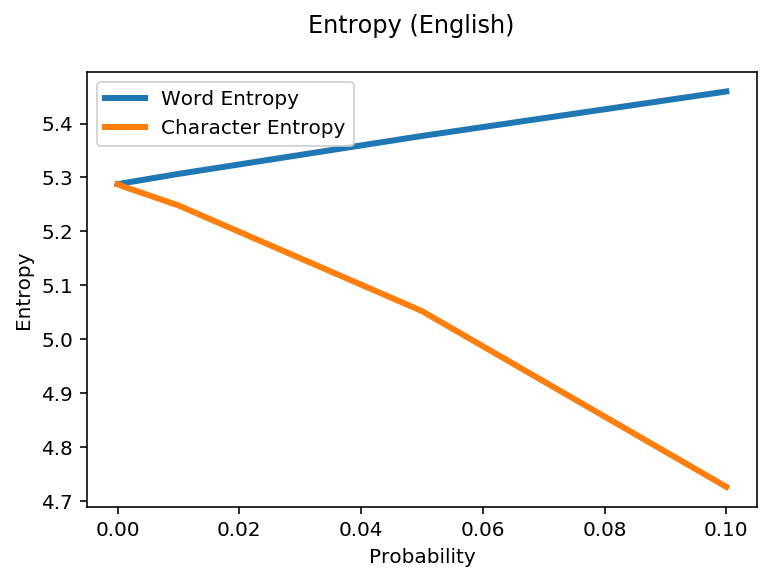

In [31]:
# English
create_plot('English', word_stats_en, char_stats_en)

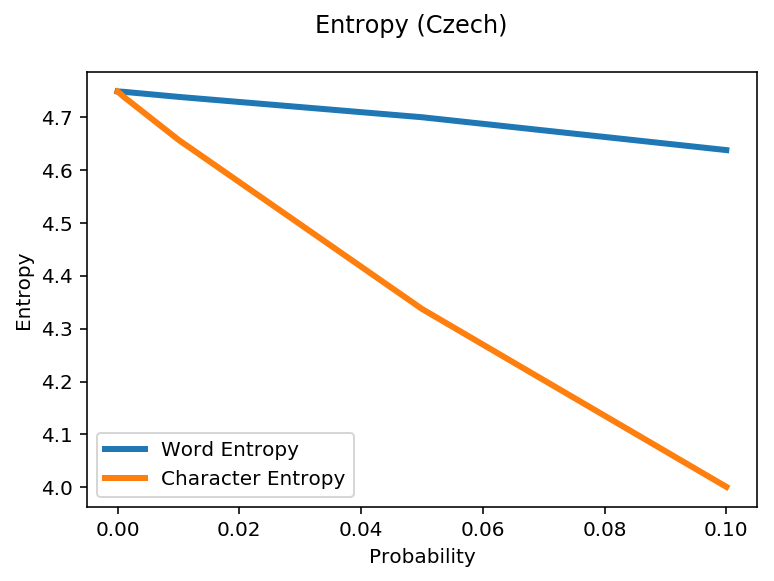

In [32]:
### Czech
create_plot('Czech', word_stats_cz, char_stats_cz)

#### Problem Statement
> Now assume two languages, $L_1$ and $L_2$ do not share any vocabulary items, and that the conditional entropy as described above of a text $T_1$ in language $L_1$ is $E$ and that the conditional entropy of a text $T_2$ in language $L_2$ is also $E$. Now make a new text by appending $T_2$ to the end of $T_1$. Will the conditional entropy of this new text be greater than, equal to, or less than $E$? Explain. [This is a paper-and-pencil exercise of course!]

Conditional entropy $H(Y|X)$ is the amount of information needed to determine the outcome of $Y$ given that the outcome $X$ is known. Since the texts are disjoint, the amount of information needed to find a word given the previous word will not increase between them (no bigrams are shared), except in one special case.

Let $T_3 = T_1 \oplus T_2$ be the concatenation of the two texts. Note that $T_3$ has a newly formed bigram on the boundary of $T_1$ and $T_2$. Let $(t_1, t_2)$ be such a bigram. Then there is a nonzero term in the conditional entropy sum, increasing $E$ by 

$$- p(t_1,t_2) \log_2 p(t_2|t_1) = - \frac{1}{|T_3|} \log_2 \frac{1}{c(t_1)} = \frac{\log_2 c(t_1)}{|T_1| + |T_2|}$$

where $c(t)$ is the number of times word $t$ appears in its text and $|T|$ is the length of $T$. In short, $E$ will increase by a small amount. If we let $|T_2| = 1$ and $c(t_1) = |T_1|$, this cannot be more than $max\{\frac{\log_2 n}{n}\} = \frac{1}{2}$ bits of information. The larger $E$ is, the more insignificant these terms will be and so the new conditional entropy will approach $E$.

---

<!-- Denote $H_C(T)$ to be the conditional entropy of a text $T$ and $|T|$ to be the length of $T$. Then

$$H_C(T) = - \sum_{i,j} p(w_i,w_j) \log_2 p(w_j|w_i) = - \sum_{i,j} \frac{c(w_i,w_j)}{|T|} \log_2 \frac{c(w_i,w_j)}{c(w_i)}$$

where $c(w_1,\dots,w_n)$ counts the frequency of an $n$-gram in $T$.

Let $T_3 = T_1 \oplus T_2$ be the concatenation of the two texts. Then $H_C(T_1) = H_C(T_2) = E$, and

$$H_C(T_3) = - \frac{1}{|T_1 + T_2|} \sum_{i,j} c(w_i,w_j) \log_2 \frac{c(w_i,w_j)}{c(w_i)}$$

If $T_1$, $T_2$ are nonempty, then $E$ must decrease, as $$. 

--- -->




### 2. Cross-Entropy and Language Modeling

#### Problem Statement
> This task will show you the importance of smoothing for language modeling, and in certain detail it lets you feel its effects.

> First, you will have to prepare data: take the same texts as in the previous task, i.e. `TEXTEN1.txt` and `TEXTCZ1.txt`

> Prepare 3 datasets out of each: strip off the last 20,000 words and call them the Test Data, then take off the last 40,000 words from what remains, and call them the Heldout Data, and call the remaining data the Training Data.

> Here comes the coding: extract word counts from the training data so that you are ready to compute unigram-, bigram- and trigram-based probabilities from them; compute also the uniform probability based on the vocabulary size. Remember (T being the text size, and V the vocabulary size, i.e. the number of types - different word forms found in the training text):

> $p_0(w_i) = 1 / V $

> $p_1(w_i) = c_1(w_i) / T$

> $p_2(w_i|w_{i-1}) = c_2(w_{i-1},w_i) / c_1(w_{i-1})$

> $p_3(w_i|w_{i-2},w_{i-1}) = c_3(w_{i-2},w_{i-1},w_i) / c_2(w_{i-2},w_{i-1})$

> Be careful; remember how to handle correctly the beginning and end of the training data with respect to bigram and trigram counts.

> Now compute the four smoothing parameters (i.e. "coefficients", "weights", "lambdas", "interpolation parameters" or whatever, for the trigram, bigram, unigram and uniform distributions) from the heldout data using the EM algorithm. [Then do the same using the training data again: what smoothing coefficients have you got? After answering this question, throw them away!] Remember, the smoothed model has the following form:

> $p_s(w_i|w_{i-2},w_{i-1}) = l_0p_0(w_i)+ l_1p_1(w_i)+ l_2p_2(w_i|w_{i-1}) + l_3p_3(w_i|w_{i-2},w_{i-1})$,

> where

> $$l_0 + l_1 + l_2 + l_3 = 1$$

> And finally, compute the cross-entropy of the test data using your newly built, smoothed language model. Now tweak the smoothing parameters in the following way: add 10%, 20%, 30%, ..., 90%, 95% and 99% of the difference between the trigram smoothing parameter and 1.0 to its value, discounting at the same the remaining three parameters proportionally (remember, they have to sum up to 1.0!!). Then set the trigram smoothing parameter to 90%, 80%, 70%, ... 10%, 0% of its value, boosting proportionally the other three parameters, again to sum up to one. Compute the cross-entropy on the test data for all these 22 cases (original + 11 trigram parameter increase + 10 trigram smoothing parameter decrease). Tabulate, graph and explain what you have got. Also, try to explain the differences between the two languages based on similar statistics as in the Task No. 2, plus the "coverage" graph (defined as the percentage of words in the test data which have been seen in the training data).

### Process Text

In [33]:
class Dataset:
    """Splits a text into training, test, and heldout sets"""
    
    def __init__(self, words):
        self.train, self.test, self.heldout = self.split_data(words)
    
    def split_data(self, words, test_size = 20000, heldout_size = 40000):
        words = list(words)
        test, remain = words[-test_size:], words[:-test_size]
        heldout, train = remain[-heldout_size:], remain[:-heldout_size]
        return train, test, heldout

In [34]:
en = Dataset(words_en)
cz = Dataset(words_cz)

In [35]:
class LanguageModel:
    """Counts words and calculates probabilities (up to trigrams)"""
    
    def __init__(self, words):
        # Prepend two tokens to avoid beginning-of-data problems
        words = np.array(['<ss>', '<s>'] + list(words))
        
        # Unigrams
        self.unigrams = words
        self.unigram_set = list(set(self.unigrams))
        self.unigram_count = len(self.unigram_set)
        self.total_unigram_count = len(self.unigrams)
        self.unigram_dist = c.Counter(self.unigrams)
        
        # Bigrams
        self.bigrams = list(nltk.bigrams(words))
        self.bigram_set = list(set(self.bigrams))
        self.bigram_count = len(self.bigram_set)
        self.total_bigram_count = len(self.bigrams)
        self.bigram_dist = c.Counter(self.bigrams)
        
        # Trigrams
        self.trigrams = list(nltk.trigrams(words))
        self.trigram_set = list(set(self.trigrams))
        self.trigram_count = len(self.trigram_set)
        self.total_trigram_count = len(self.trigrams)
        self.trigram_dist = c.Counter(self.trigrams)
    
    def count(ngrams):
        ngram_set = list(set(ngrams))
        ngram_count = len(ngram_set)
        total_ngram_count = len(ngrams)
        ngram_dist = c.Counter(ngrams)
        return ngram_set, ngram_count, total_ngram_count, ngram_dist
        
    def p_uniform(self):
        """Calculates the probability of choosing a word uniformly at random"""
        return self.div(1, self.unigram_count)
    
    def p_unigram(self, w):
        """Calculates the probability a unigram appears in the distribution"""
        return self.div(self.unigram_dist[w], self.total_unigram_count)
    
    def p_bigram_cond(self, wprev, w):
        """Calculates the probability a word appears in the distribution given the previous word"""
        # If neither ngram has been seen, use the uniform distribution for smoothing purposes
        if ((self.bigram_dist[wprev, w], self.unigram_dist[wprev]) == (0,0)):
            return self.p_uniform()
        
        return self.div(self.bigram_dist[wprev, w], self.unigram_dist[wprev])
    
    def p_trigram_cond(self, wprev2, wprev, w):
        """Calculates the probability a word appears in the distribution given the previous word"""
        # If neither ngram has been seen, use the uniform distribution for smoothing purposes
        if ((self.trigram_dist[wprev2, wprev, w], self.bigram_dist[wprev2, wprev]) == (0,0)):
            return self.p_uniform()
        
        return self.div(self.trigram_dist[wprev2, wprev, w], self.bigram_dist[wprev2, wprev])
    
    def div(self, a, b):
        """Divides a and b safely"""
        return a / b if b != 0 else 0

In [36]:
lm_en = LanguageModel(en.train)
lm_cz = LanguageModel(cz.train)

### Expectation Maximization
Compute the EM algorithm on a language model using linear interpolation smoothing

In [37]:
def init_lambdas(n=3):
    """Initializes a list of lambdas for an ngram language model with uniform probabilities"""
    return [1 / (n + 1)] * (n + 1)

In [38]:
def p_smoothed(lm, lambdas, wprev2, wprev, w):
    """Calculate the smoothed trigram probability using the weighted product of lambdas"""
    return np.multiply(lambdas, [
        lm.p_uniform(),
        lm.p_unigram(w),
        lm.p_bigram_cond(wprev, w),
        lm.p_trigram_cond(wprev2, wprev, w)
    ])

In [39]:
def expected_counts(lm, lambdas, heldout):
    smoothed_probs = (p_smoothed(lm, lambdas, *trigram) for trigram in heldout) # Multiply lambdas by probabilities
    return np.sum(smoothed / np.sum(smoothed) for smoothed in smoothed_probs) # Element-wise sum

In [40]:
def next_lambda(lm, lambdas, heldout):
    expected = expected_counts(lm, lambdas, heldout)
    return expected / np.sum(expected) # Normalize the expected counts

In [41]:
def em_algorithm(train, heldout, stop_tolerance=1e-4):
    lambdas = init_lambdas(3)
    
    lm = LanguageModel(train)
    heldout_trigrams = LanguageModel(heldout).trigrams
    
    next_l = next_lambda(lm, lambdas, heldout_trigrams)
    while not np.all([diff < stop_tolerance for diff in np.abs(lambdas - next_l)]):
        print(next_l)
        lambdas = next_l
        next_l = next_lambda(lm, lambdas, heldout_trigrams)

    lambdas = next_l
    return lambdas

In [42]:
def log_sum(lm, lambdas, trigram):
    return np.log2(np.sum(p_smoothed(lm, lambdas, *trigram)))

In [43]:
def cross_entropy(lm, lambdas, test_trigrams):
    return - np.sum(log_sum(lm, lambdas, trigram) for trigram in test_trigrams) / len(test_trigrams)

In [44]:
lambdas_en = em_algorithm(en.train, en.heldout)

[ 0.1167227   0.25146042  0.39226722  0.23954967]
[ 0.08476114  0.24901516  0.45003149  0.21619221]
[ 0.07515902  0.25031709  0.47297039  0.20155351]
[ 0.07187272  0.25195344  0.48276684  0.193407  ]
[ 0.07068217  0.25301978  0.48732437  0.18897369]
[ 0.0702484   0.25358385  0.48960044  0.18656732]
[ 0.07009806  0.25384935  0.4907949   0.1852577 ]
[ 0.07005358  0.25396265  0.4914418   0.18454197]
[ 0.0700467   0.25400537  0.49179892  0.18414901]
[ 0.07005135  0.25401801  0.49199835  0.18393229]
[ 0.07005808  0.25401916  0.49211052  0.18381223]


In [45]:
lambdas_cz = em_algorithm(cz.train, cz.heldout)

[ 0.1899329   0.35653922  0.25131758  0.2022103 ]
[ 0.16412405  0.40071394  0.24863114  0.18653087]
[ 0.15269193  0.41771789  0.24710633  0.18248385]
[ 0.14722217  0.42425682  0.24627602  0.18224499]
[ 0.14438273  0.42684192  0.24575405  0.1830213 ]
[ 0.14279869  0.42791641  0.24539627  0.18388863]
[ 0.14186393  0.42839581  0.24514624  0.18459402]
[ 0.14128994  0.42862862  0.24497302  0.18510841]
[ 0.14092816  0.42875178  0.24485474  0.18546532]
[ 0.14069638  0.42882187  0.24477499  0.18570677]
[ 0.1405464   0.42886398  0.24472172  0.1858679 ]
[ 0.1404488   0.4288902   0.24468638  0.18597462]


In [46]:
trigrams_en = LanguageModel(en.test).trigrams
cross_entropy(lm_en, lambdas_en, trigrams_en)

7.4685015308409346

In [47]:
trigrams_cz = LanguageModel(cz.test).trigrams
cross_entropy(lm_cz, lambdas_cz, trigrams_cz)

10.220892665234681

In [48]:
def tweak_trigram_lambda(lambdas, amount):
    """Adds the given amount to the trigram lambda and removes 
    the same amount from the other lambdas (normalized)"""
    first = np.multiply(lambdas[:-1], (1.0 - amount / np.sum(lambdas[:-1])))
    last =  lambdas[-1] + amount
    return np.append(first, last)

In [49]:
boost_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99] # Boost trigram by this amount
discount_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Discount trigram by this amount

In [57]:
def boost_stats(lm, test, lambdas):
    boost = pd.DataFrame(columns=['boost_trigram', 'cross_entropy'])
    
    trigrams = LanguageModel(test).trigrams
    
    for p in boost_ratios:
        lambdas_tweaked = tweak_trigram_lambda(lambdas, p * (1 - lambdas[-1]))
        entropy = cross_entropy(lm, lambdas_tweaked, trigrams)
        boost.loc[len(boost)] = [p, entropy]
    
    return boost

In [58]:
def discount_stats(lm, test, lambdas):
    discount = pd.DataFrame(columns=['discount_trigram', 'cross_entropy'])
    
    trigrams = LanguageModel(test).trigrams
    
    for p in discount_ratios:
        lambdas_tweaked = tweak_trigram_lambda(lambdas, (p - 1) * lambdas[-1])
        entropy = cross_entropy(lm, lambdas_tweaked, trigrams)
        discount.loc[len(discount)] = [p, entropy]
    
    return discount

In [69]:
boost_en, discount_en = boost_stats(lm_en, en.test, lambdas_en), discount_stats(lm_en, en.test, lambdas_en)
boost_cz, discount_cz = boost_stats(lm_cz, cz.test, lambdas_cz), discount_stats(lm_cz, cz.test, lambdas_cz)

In [67]:
boost_en

,boost_trigram,cross_entropy
0,0.10,7.470109
1,0.20,7.497021
2,0.30,7.546810
3,0.40,7.620527
4,0.50,7.722379
5,0.60,7.861088
6,0.70,8.054209
7,0.80,8.341898
8,0.90,8.851131
9,0.95,9.362468


In [68]:
discount_en

,discount_trigram,cross_entropy
0,0.0,7.704275
1,0.1,7.617336
2,0.2,7.576532
3,0.3,7.547883
4,0.4,7.526211
5,0.5,7.509353
6,0.6,7.496144
7,0.7,7.485868
8,0.8,7.478045
9,0.9,7.472339


In [71]:
boost_cz

,boost_trigram,cross_entropy
0,0.10,10.225338
1,0.20,10.254777
2,0.30,10.306870
3,0.40,10.382650
4,0.50,10.486207
5,0.60,10.626002
6,0.70,10.818994
7,0.80,11.103764
8,0.90,11.601299
9,0.95,12.093600


In [72]:
discount_cz

,discount_trigram,cross_entropy
0,0.0,10.489513
1,0.1,10.368989
2,0.2,10.326035
3,0.3,10.296946
4,0.4,10.275387
5,0.5,10.258881
6,0.6,10.246145
7,0.7,10.236411
8,0.8,10.229174
9,0.9,10.224086


In [76]:
def create_lambdas_plot(label, discount_stats, boost_stats):
    plt.plot(discount_stats.discount_trigram, discount_stats.cross_entropy, label='Discount Entropy')
    plt.plot(boost_stats.boost_trigram, boost_stats.cross_entropy, label='Boost Entropy')
    plt.suptitle('Entropy (' + label + ')')
    plt.xlabel('Probability')
    plt.ylabel('Cross Entropy')
    _ = plt.legend()

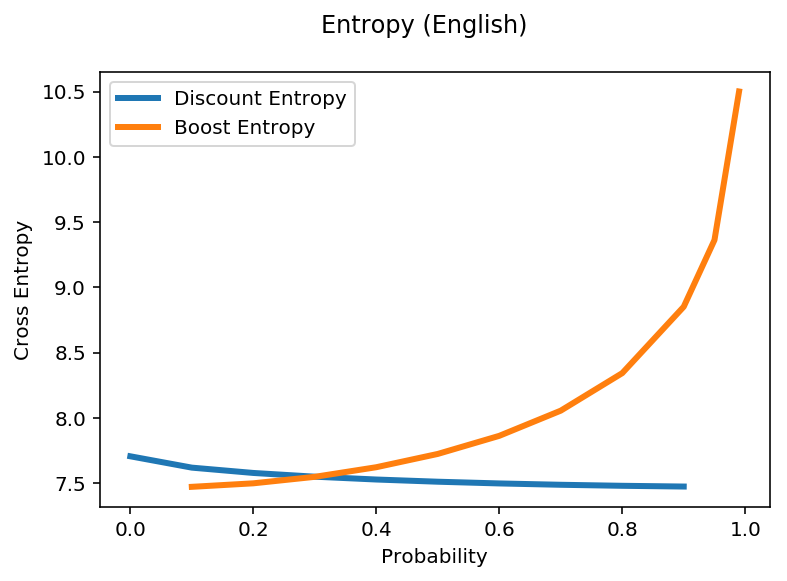

In [77]:
# English
create_lambdas_plot('English', discount_en, boost_en)

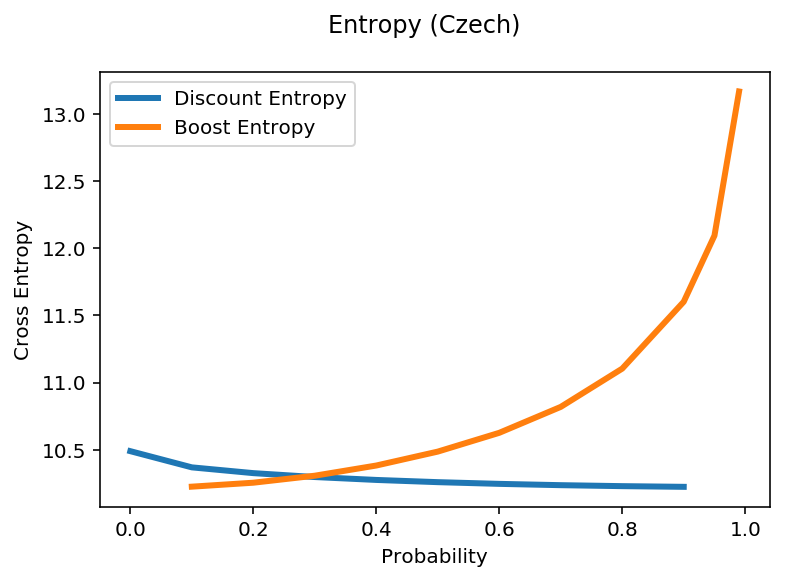

In [78]:
# Czech
create_lambdas_plot('Czech', discount_cz, boost_cz)